# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento das bases**
3. **Análise dos dataframes**
4. **Modelagem preditiva**
    - 4.1. Preparação dos dados
    - 4.2. Treinamento dos modelos com todo o histórico de dados
    - 4.3. Treinamento dos modelos com histórico de dados a partir de 01-01-2014
    - 4.4. Treinamento dos modelos com histórico de dados a partir de 01-01-2015
    - 4.5. Comparativo dos resultados
5. **Tunagem dos hiperparâmetros do modelo com Optuna**
6. **Salvando e testando o desempenho do modelo**
    - 6.1. Salvando o modelo (.pkl)
    - 6.2. Comparativo de resultados
7. **Testando o algoritmo XGBoost**
    - 7.1. Tunagem do modelo com Optuna
    - 7.2. Salvando e testando o desempenho do modelo
    - 7.3. Comparativo de resultados
8. **Testando o algoritmo CatBoost**
    - 8.1. Tunagem do modelo com Optuna
    - 8.2. Salvando e testando o desempenho do modelo
    - 8.3. Comparativo de resultados
9. **Teste de aplicação do Voting Ensemble**
10. **Análise da distribuição dos erros**
11. **Comparação: valores reais x valores preditos**

<br>

---

<br>

## 1. Importação de bibliotecas

In [1]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna
import joblib
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from optuna.samplers import TPESampler

In [2]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar opção para exibir todas as linhas do Dataframe
pd.set_option('display.max_rows', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Suprimir logs do Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Configurar estilo dos gráficos do Seaborn
sns.set_style('whitegrid')

## 2. Carregamento das bases

In [3]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 0


In [4]:
# Criando um dataframe a partir do arquivo train_001.csv

df_train = pd.read_csv('dados/train_001.csv', sep=',')
print('\nDATAFRAME: df_train')
df_train.head()


DATAFRAME: df_train


,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,PromoRollingSum_21,PromoRollingSum_28,PromoRollingSum_30,PromoRollingSum_60,PromoRollingSum_90,PromoRollingSum_120,PromoRollingSum_150,PromoRollingSum_180,PromoRollingSum_360,Target
0,1,1,2015-06-30,1,1,0,0,c,a,1270.0,...,9.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,149389.0
1,2,1,2015-06-30,1,1,0,0,a,a,570.0,...,9.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,170586.0
2,3,1,2015-06-30,1,1,0,1,a,a,14130.0,...,9.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,243725.0
3,4,1,2015-06-30,1,1,0,0,c,c,620.0,...,9.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,334601.0
4,5,1,2015-06-30,1,1,0,0,a,a,29910.0,...,9.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,162182.0


In [5]:
# Criando um dataframe a partir do arquivo validation_001.csv

df_validation = pd.read_csv('dados/validation_001.csv', sep=',')
print('\nDATAFRAME: df_validation')
df_validation.head()


DATAFRAME: df_validation


,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,PromoRollingSum_21,PromoRollingSum_28,PromoRollingSum_30,PromoRollingSum_60,PromoRollingSum_90,PromoRollingSum_120,PromoRollingSum_150,PromoRollingSum_180,PromoRollingSum_360,Target
0,1,4,2015-07-31,1,1,0,1,c,a,1270.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157057.0
1,2,4,2015-07-31,1,1,0,1,a,a,570.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176872.0
2,3,4,2015-07-31,1,1,0,1,a,a,14130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245876.0
3,4,4,2015-07-31,1,1,0,1,c,c,620.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,355383.0
4,5,4,2015-07-31,1,1,0,1,a,a,29910.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162083.0


## 3. Análise dos dataframes

In [6]:
# Exibindo a quantidade de linhas e colunas dos dataframes

# Criação de um dicionário com os dataframes e seus respectivos nomes
dfs = {
    'df_train': df_train,
    'df_validation': df_validation
}

# Iteração sobre o dicionário para exibir o nome e as dimensões dos dataframes
print(f'\nVOLUMETRIA')
for nome, df in dfs.items():
    print(f'\n{nome}')
    print(f'-'*45)
    print(f'Quantidade de linhas (registros):  {df.shape[0]}')
    print(f'Quantidade de colunas (variáveis): {df.shape[1]}')    


VOLUMETRIA

df_train
---------------------------------------------
Quantidade de linhas (registros):  943795
Quantidade de colunas (variáveis): 38

df_validation
---------------------------------------------
Quantidade de linhas (registros):  34565
Quantidade de colunas (variáveis): 38


In [7]:
# Função para geração de um dataframe de metadados

def gerar_metadados(dataframe):
    '''
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: Dataframe
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadados = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum()/len(dataframe))*100, 2),
        'Cardinalidade': dataframe.nunique(),
    })
    metadados = metadados.sort_values(by='Qtde de nulos', ascending=False)
    metadados = metadados.reset_index(drop=True)
    return metadados

In [8]:
gerar_metadados(df_train)

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,Store,int64,0,0.0,1115
1,PromoRollingSum_21,float64,0,0.0,7
2,DayOfYear,int64,0,0.0,365
3,MonthsSinceTheCompetitionOpened,float64,0,0.0,336
4,YearsSinceTheCompetitionOpened,float64,0,0.0,346
5,PromoRollingSum_3,float64,0,0.0,4
6,PromoRollingSum_5,float64,0,0.0,6
7,PromoRollingSum_7,float64,0,0.0,6
8,PromoRollingSum_14,float64,0,0.0,11
9,PromoRollingSum_28,float64,0,0.0,11


## 4. Modelagem preditiva

### 4.1. Preparação dos dados

In [9]:
# Separando as variáveis preditivas e a variável preditora (alvo)

features = df_train.columns.drop('Target')
target = 'Target'

In [10]:
# Separando as variáveis numéricas e categóricas

numerical_features = df_train[features].select_dtypes(exclude=object).columns
categorical_features = df_train[features].select_dtypes(include=object).columns

In [11]:
# Converter todas as colunas categóricas para string

df_train[categorical_features] = df_train[categorical_features].astype(str)
df_validation[categorical_features] = df_validation[categorical_features].astype(str)

In [12]:
# Separando os dataframes com as variáveis preditivas e a variável preditora

X_train = df_train[features]
y_train = df_train[target]
X_test = df_validation[features]
y_test = df_validation[target]

In [13]:
# Pré-processamento, transformação das features numéricas e categóricas

preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), numerical_features),
		('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [14]:
# Verificando os shapes

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (943795, 37), y_train: (943795,)
Shape: X_test:  (34565, 37),  y_test: (34565,)


In [15]:
# Verificando transformação de dados

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [16]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_transformed.shape}')
print(f'Shape de X_test após transformação:  {X_test_transformed.shape}')

Shape de X_train após transformação: (943795, 958)
Shape de X_test após transformação:  (34565, 958)


### 4.2. Treinamento dos modelos com todo o histórico de dados

In [17]:
# Definindo os modelos a serem testados

models = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='MAE', verbose=0),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}

In [18]:
def models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor):
    '''
    Avalia modelos de aprendizado de máquina, calculando métricas de desempenho 
    no conjunto de treino e teste.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.

    :return: list
        Lista contendo os resultados de avaliação de cada modelo, RMSE e MAE para treino 
        e teste, além do tempo de execução.
    '''
    results = []

    for model_name, model in models.items():
        # Cria um pipeline que combina o pré-processamento e o modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

        # Registra o tempo de início
        start_time = time.time()
        
        # Treina o modelo usando o pipeline
        pipeline.fit(X_train, y_train)
        
        # Registra o tempo de término e calcula o tempo de execução
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Previsões e cálculo das métricas no conjunto de treino
        train_predictions = pipeline.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)

        # Previsões e cálculo das métricas no conjunto de teste
        test_predictions = pipeline.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        test_mae = mean_absolute_error(y_test, test_predictions)

        # Adiciona os resultados à lista
        results.append((
            model_name, train_rmse, test_rmse, train_mae, test_mae, elapsed_time
        ))

    return results

In [19]:
# Avaliando os modelos
results = models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
results_df = pd.DataFrame(results, columns=[
                            'Modelo', 'RMSE em treino', 'RMSE em teste', 
                            'MAE em treino', 'MAE em teste', 'Tempo decorrido (s)'])

# Exibindo os resultados
results_df

,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
0,LinearRegression,74600.379064,309293.409817,51738.388898,271276.664045,28.248643
1,ElasticNet,84935.244853,87519.132897,61460.551956,63554.317987,55.603750
2,LightGBM,38586.776903,44161.800849,27936.856770,32487.902792,11.839526
3,CatBoost,67985.801128,73214.229602,40463.759302,45533.101445,20.887834
4,GradientBoosting,65562.258359,70611.741017,45250.375402,48747.665342,335.386967
5,XGBoost,21462.326807,28607.617056,15610.326833,21221.732968,9.811405


### 4.3. Treinamento dos modelos com histórico de dados a partir de 01-01-2014

In [20]:
# Selecionando dados a partir de 01-01-2014
df_train_00 = df_train[df_train['Date'] >= '2014-01-01'].copy()

# Converter todas as colunas categóricas para string
df_train_00[categorical_features] = df_train_00[categorical_features].astype(str)

# Separando os dataframes com as variáveis preditivas e a variável preditora
X_train_00 = df_train_00[features]
y_train_00 = df_train_00[target]

# Pré-processamento, transformação das features numéricas e categóricas
preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), numerical_features),
		('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Avaliando os modelos
results = models_evaluation(models, X_train_00, y_train_00, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
results_df_00 = pd.DataFrame(results, columns=[
                            'Modelo', 'RMSE em treino', 'RMSE em teste', 
                            'MAE em treino', 'MAE em teste', 'Tempo decorrido (s)'])

# Exibindo os resultados
results_df_00

,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
0,LinearRegression,74409.362859,276823.117601,51872.836322,240122.218335,17.610223
1,ElasticNet,85217.698738,87332.278344,61768.541665,62443.225486,18.393986
2,LightGBM,37508.232887,42825.956651,27228.816279,31749.433281,6.738651
3,CatBoost,66946.740114,72510.606671,40045.071795,45477.246849,11.919119
4,GradientBoosting,64445.219168,69331.655819,44933.129775,48135.930325,201.910770
5,XGBoost,19679.021450,25890.517653,14269.371007,19121.840148,5.315342


### 4.4. Treinamento dos modelos com histórico de dados a partir de 01-01-2015

In [21]:
# Selecionando dados a partir de 01-01-2015
df_train_01 = df_train[df_train['Date'] >= '2015-01-01'].copy()

# Converter todas as colunas categóricas para string
df_train_01[categorical_features] = df_train_01[categorical_features].astype(str)

# Separando os dataframes com as variáveis preditivas e a variável preditora
X_train_01 = df_train_01[features]
y_train_01 = df_train_01[target]

# Pré-processamento, transformação das features numéricas e categóricas
preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), numerical_features),
		('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Avaliando os modelos
results = models_evaluation(models, X_train_01, y_train_01, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
results_df_01 = pd.DataFrame(results, columns=[
                            'Modelo', 'RMSE em treino', 'RMSE em teste', 
                            'MAE em treino', 'MAE em teste', 'Tempo decorrido (s)'])

# Exibindo os resultados
results_df_01

,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
0,LinearRegression,73699.366946,86771.077084,51404.782369,60645.653521,2.232295
1,ElasticNet,84534.496771,92563.807514,61196.068350,61898.764900,4.950615
2,LightGBM,35155.499255,40311.140946,25778.097047,29902.591028,2.588247
3,CatBoost,67510.325688,74015.997350,40817.270692,46240.349720,4.108876
4,GradientBoosting,63451.163306,69028.536458,44110.979695,47900.685039,55.316699
5,XGBoost,18390.785339,24604.677229,13493.532465,18316.927099,1.759362


### 4.5. Comparativo dos resultados

In [22]:
# Utilizando todo o histórico de dados
# Exibindo os resultados
results_df

,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
0,LinearRegression,74600.379064,309293.409817,51738.388898,271276.664045,28.248643
1,ElasticNet,84935.244853,87519.132897,61460.551956,63554.317987,55.603750
2,LightGBM,38586.776903,44161.800849,27936.856770,32487.902792,11.839526
3,CatBoost,67985.801128,73214.229602,40463.759302,45533.101445,20.887834
4,GradientBoosting,65562.258359,70611.741017,45250.375402,48747.665342,335.386967
5,XGBoost,21462.326807,28607.617056,15610.326833,21221.732968,9.811405


Os valores elevados de **RMSE** e **MAE** podem ser atribuídos à grande variação na variável dependente _'Target'_, que inclui dias com vendas zero e dias com vendas muito elevadas. Esse cenário reflete a realidade de que drogarias podem estar fechadas ou operar em horários reduzidos, o que influencia os dados. O foco, no entanto, deve ser nas diferenças entre as métricas de treino e teste, o que indica a capacidade dos modelos em **generalizar**, ou seja, manter um bom desempenho ao receber dados novos (não vistos).

Dentre os modelos analisados, o **LinearRegression** teve o pior desempenho com os maiores valores de erro. O **GradientBoosting** apresentou boas diferenças entre treino e teste, mas os erros ainda foram elevados, além de apresentar o pior tempo de execução. O **CatBoost** se destacou com métricas razoáveis, mas seu tempo de execução foi elevado em relação aos próximos modelos. O **XGBoost** obteve os menores valores de _RMSE_ e _MAE_ em comparação aos demais modelos, porém com uma diferença maior entre treino e teste, indicando possível overfitting. O **LightGBM**, com _RMSE_ e _MAE_ competitivos e o menor tempo de execução, mostrou-se o modelo mais equilibrado, oferecendo a melhor performance geral.

## 5. Tunagem dos hiperparâmetros do modelo com Optuna

In [23]:
def objective_lightgbm(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo LGBMRegressor usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''      
    model = lgb.LGBMRegressor(
        # Número de árvores (boosting rounds) no modelo, cada árvore corrige os erros da anterior
        n_estimators=trial.suggest_int('n_estimators', 300, 500),
        # Taxa de aprendizado para ajustar o impacto de cada árvore
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.04, log=True),
        # Limita a profundidade máxima de cada árvore, controlando o crescimento da árvore e prevenindo overfitting
        max_depth=trial.suggest_int('max_depth', 3, 7),
        # Número máximo de folhas em cada árvore. Controla a complexidade do modelo
        num_leaves=trial.suggest_int('num_leaves', 20, 90),
        # Proporção de amostras usadas para treinar cada árvore, útil para prevenir overfitting
        subsample=trial.suggest_float('subsample', 0.5, 0.9),
        # Proporção de colunas (features) usadas para construir cada árvore, ajuda a reduzir correlação entre árvores e evitar overfitting
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 1.0),
        # Regularização L1 (Lasso), adiciona penalidade proporcional ao valor absoluto dos coeficientes, ajudando a reduzir o overfitting
        reg_alpha=trial.suggest_float('reg_alpha', 0.1, 10, log=True),
        # Regularização L2 (Ridge), adiciona penalidade proporcional ao quadrado dos coeficientes, ajudando a reduzir o overfitting
        reg_lambda=trial.suggest_float('reg_lambda', 0.01, 10, log=True),
        # Semente aleatória para garantir reprodutibilidade dos resultados
        random_state=42,
        # Silenciar a saída de logs durante o treinamento
        verbose=-1       
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Treina o modelo usando o pipeline
    pipeline.fit(X_train, y_train)
   
    # Previsões e cálculo das métricas no conjunto de teste
    test_predictions = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    return test_mae

In [103]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_lightgbm, n_trials=50, n_jobs=-1, show_progress_bar=True, timeout=1800)

  0%|          | 0/50 [00:00<?, ?it/s]

In [105]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_lightgbm = study.best_value
params_lightgbm = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'n_estimators': 467, 'learning_rate': 0.03833820921489225, 'max_depth': 7, 'num_leaves': 70, 'subsample': 0.5805423737123789, 'colsample_bytree': 0.8124503275340907, 'reg_alpha': 0.4510330249910037, 'reg_lambda': 0.02761451908267608}

Melhor MAE: 23419.0702


## 6. Salvando e testando o desempenho do modelo

### 6.1. Salvando o modelo (.pkl)

In [106]:
def train_and_save_model(best_model, file_name, model_name, X_train, y_train, X_test, y_test):
    '''
    Treina um modelo com os melhores hiperparâmetros, salva o pipeline treinado 
    em um arquivo e avalia o desempenho no conjunto de teste.

    :param best_model: object
        O modelo otimizado com os melhores hiperparâmetros a ser treinado.
    :param file_name: str
        Nome do arquivo para salvar o pipeline treinado (formato .pkl).
    :param model_name: str
        Nome do modelo para identificação nos resultados.
    :param X_train: array-like ou DataFrame
        Conjunto de características para treinamento.
    :param y_train: array-like ou Series
        Variável alvo correspondente ao conjunto de treinamento.
    :param X_test: array-like ou DataFrame
        Conjunto de características para teste.
    :param y_test: array-like ou Series
        Variável alvo correspondente ao conjunto de teste.

    :return: list
        Lista contendo o nome do modelo, o RMSE e o MAE calculados no conjunto 
        de teste, para avaliação do desempenho.
    '''
    results = []
    
    # Recriando o pipeline com os melhores hiperpârametros
    pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('model', best_model)])
    
    # Registra o tempo de início
    start_time = time.time()
    
    # Treinando o pipeline final no conjunto de treinamento
    pipeline_best_model.fit(X_train, y_train)
    
    # Registra o tempo de término e calcula o tempo de execução
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    try:
        # Salvando o pipeline em um arquivo .pkl
        joblib.dump(pipeline_best_model, f'modelos/{file_name}.pkl')
        print(f'Arquivo {file_name}.pkl gerado com sucesso!')
    except Exception as e:
        print(f'Erro ao salvar o pipeline: {e}')
        
    # Previsões e cálculo das métricas no conjunto de treino
    train_predictions = pipeline_best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    
    # Previsões e cálculo das métricas no conjunto de teste
    test_predictions = pipeline_best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    # Adiciona previsões em teste a lista
    results.append((
        model_name, train_rmse, test_rmse, train_mae, test_mae, elapsed_time
    ))
    
    return results

In [107]:
# Parâmetros otimizados para o LightGBM
best_params = params_lightgbm

# Cria o modelo com os melhores hiperparâmetros
best_model = lgb.LGBMRegressor(**best_params, verbose=-1)

# Treina o modelo e salva o pipeline treinado em um arquivo .pkl
results_lightgbm = train_and_save_model(best_model, 'pipeline_best_model_lightgbm', 'LightGBM',
                                        X_train, y_train, X_test, y_test)

Arquivo pipeline_best_model_lightgbm.pkl gerado com sucesso!


### 6.2. Comparativo de resultados

In [108]:
# Definindo as colunas para o DataFrame
columns = ['Modelo', 'RMSE em treino', 'RMSE em teste', 'MAE em treino', 
           'MAE em teste', 'Tempo decorrido (s)']

# Criando DataFrame com os resultados do modelo LightGBM
df_results_lightgbm = pd.DataFrame(results_lightgbm, columns=columns)

In [109]:
print('\nResultado do modelo SEM a tunagem de hiperparâmetros')
results_df.iloc[[2], 0:6]


Resultado do modelo SEM a tunagem de hiperparâmetros


,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
2,LightGBM,38586.776903,44161.800849,27936.85677,32487.902792,11.839526


In [110]:
print('\nResultado do modelo COM a tunagem de hiperparâmetros')
df_results_lightgbm


Resultado do modelo COM a tunagem de hiperparâmetros


,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
0,LightGBM,26568.716275,32165.355624,19251.483054,23595.982089,26.046391


A tunagem de hiperparâmetros trouxe uma melhoria na redução da diferença entre os valores das métricas **RMSE** e **MAE** nos conjuntos de dados de **treino** e **teste**, o que indica que os ajustes de hiperparâmetros ajudaram os modelos a capturar melhor os padrões dos dados.

O modelo **LightGBM** apresentou uma melhoria nas métricas de erro **RMSE** e **MAE** após a tunagem, indicando que o modelo agora está prevendo com erros menores e com uma melhor capacidade de **generalização**. Houve uma redução tanto nos valores das métricas quanto nas diferenças entre os resultados de treino e teste. O **LightGBM** continua se destacando como o modelo mais equilibrado, com redução das métricas de **RMSE** e **MAE**, aliado à melhor capacidade de generalização.

## 7. Testando o algoritmo XGBoost

### 7.1. Tunagem do modelo com Optuna

In [31]:
def objective_xgboost(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo XGBRegressor usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''   
    model = XGBRegressor(
        # Número de árvores (boosting rounds) no modelo, cada árvore corrige os erros da anterior
        n_estimators=trial.suggest_int('n_estimators', 300, 500),        
        # Taxa de aprendizado para ajustar o impacto de cada árvore
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.04, log=True),        
        # Limita a profundidade máxima de cada árvore, controlando o crescimento da árvore e prevenindo overfitting
        max_depth=trial.suggest_int('max_depth', 3, 7),        
        # Número máximo de folhas em cada árvore. Controla a complexidade do modelo
        max_leaves=trial.suggest_int('max_leaves', 20, 90),        
        # Proporção de amostras usadas para treinar cada árvore, útil para prevenir overfitting
        subsample=trial.suggest_float('subsample', 0.5, 0.9),       
        # Proporção de colunas (features) usadas para construir cada árvore, ajuda a reduzir correlação entre árvores e evitar overfitting
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 1.0),        
        # Regularização L1 (Lasso), adiciona penalidade proporcional ao valor absoluto dos coeficientes, ajudando a reduzir o overfitting
        reg_alpha=trial.suggest_float('reg_alpha', 0.1, 10, log=True),
        # Regularização L2 (Ridge), adiciona penalidade proporcional ao quadrado dos coeficientes, ajudando a reduzir o overfitting
        reg_lambda=trial.suggest_float('reg_lambda', 0.01, 10, log=True),
        # Semente aleatória para garantir reprodutibilidade dos resultados
        random_state=42,
        # Silenciar a saída de logs durante o treinamento
        verbosity=0,
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Treina o modelo usando o pipeline
    pipeline.fit(X_train, y_train)
   
    # Faz previsões no conjunto de teste e calcula as métricas
    test_predictions = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    return test_mae

In [32]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_xgboost, n_trials=50, n_jobs=-1, show_progress_bar=True, timeout=1800)

  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_xgboost = study.best_value
params_xgboost = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'n_estimators': 497, 'learning_rate': 0.02984997380796835, 'max_depth': 7, 'max_leaves': 90, 'subsample': 0.7371908729645792, 'colsample_bytree': 0.8685283603826094, 'reg_alpha': 0.2684936674225752, 'reg_lambda': 1.119848476606604}

Melhor MAE: 25876.6605


### 7.2. Salvando e testando o desempenho do modelo

In [34]:
# Parâmetros otimizados para o XGBoost
best_params = params_xgboost

# Cria o modelo com os melhores hiperparâmetros
best_model = XGBRegressor(**best_params, verbosity=0)

# Treina o modelo e salva o pipeline treinado em um arquivo .pkl
results_xgboost = train_and_save_model(best_model, 'pipeline_best_model_xgboost', 'XGBoost',
                                       X_train, y_train, X_test, y_test)

Arquivo pipeline_best_model_xgboost.pkl gerado com sucesso!


### 7.3. Comparativo de resultados

In [35]:
# Definindo as colunas para o DataFrame
columns = ['Modelo', 'RMSE em treino', 'RMSE em teste', 'MAE em treino', 
           'MAE em teste', 'Tempo decorrido (s)']

# Criando DataFrame com os resultados do modelo XGBoost
df_results_xgboost = pd.DataFrame(results_xgboost, columns=columns)

In [36]:
print('\nResultado do modelo SEM a tunagem de hiperparâmetros')
results_df.iloc[[5], 0:6]


Resultado do modelo SEM a tunagem de hiperparâmetros


,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
5,XGBoost,21462.326807,28607.617056,15610.326833,21221.732968,9.811405


In [37]:
print('\nResultado do modelo COM a tunagem de hiperparâmetros')
df_results_xgboost


Resultado do modelo COM a tunagem de hiperparâmetros


,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
0,XGBoost,30645.068833,36256.118494,21968.653544,26354.57338,34.039545


## 8. Testando o algoritmo CatBoost

### 8.1. Tunagem do modelo com Optuna

In [38]:
def objective_catboost(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo CatBoost usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''
    model = cb.CatBoostRegressor(
        # Número de árvores (boosting rounds) no modelo, cada árvore corrige os erros da anterior
        n_estimators=trial.suggest_int('n_estimators', 300, 500),        
        # Taxa de aprendizado para ajustar o impacto de cada árvore
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.04, log=True),        
        # Limita a profundidade máxima de cada árvore, controlando o crescimento da árvore e prevenindo overfitting
        max_depth=trial.suggest_int('max_depth', 3, 7),        
        # Regularização L2 (substitui reg_alpha e reg_lambda)
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.1, 10, log=True),      
        # Proporção de amostras usadas para treinar cada árvore, útil para prevenir overfitting
        subsample=trial.suggest_float('subsample', 0.5, 0.9),       
        # Subamostragem de features
        colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.7, 1.0),  
        # Semente aleatória para garantir reprodutibilidade dos resultados
        random_state=42,
        # Silenciar a saída de logs durante o treinamento
        verbose=0,
    ) 

    # Cria o pipeline com o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Treina o modelo
    pipeline.fit(X_train, y_train)

    # Previsões e cálculo do MAE no conjunto de teste
    test_predictions = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    return test_mae

In [63]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_catboost, n_trials=50, n_jobs=-1, show_progress_bar=True, timeout=1800)

  0%|          | 0/50 [00:00<?, ?it/s]

In [64]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_catboost = study.best_value
params_catboost = study.best_params

print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'\nMelhor MAE: {study.best_value:.4f}')

Melhores hiperparâmetros: {'n_estimators': 482, 'learning_rate': 0.03986548425355291, 'max_depth': 7, 'l2_leaf_reg': 0.3210988448273863, 'subsample': 0.7966195933821545, 'colsample_bylevel': 0.9619976182479291}

Melhor MAE: 34536.5655


### 8.2. Salvando e testando o desempenho do modelo

In [65]:
# Parâmetros otimizados para o BaggingRegressor
best_params = params_catboost

# Cria o modelo com os melhores hiperparâmetros
best_model = cb.CatBoostRegressor(**best_params, verbose=0)

# Treina o modelo e salva o pipeline treinado em um arquivo .pkl
results_catboost = train_and_save_model(best_model, 'pipeline_best_model_catboost', 'CatBoost',
                                       X_train, y_train, X_test, y_test)

Arquivo pipeline_best_model_catboost.pkl gerado com sucesso!


### 8.3. Comparativo de resultados

In [66]:
# Definindo as colunas para o DataFrame
columns = ['Modelo', 'RMSE em treino', 'RMSE em teste', 'MAE em treino', 
           'MAE em teste', 'Tempo decorrido (s)']

# Criando DataFrame com os resultados do modelo BaggingRegressor
df_results_catboost = pd.DataFrame(results_catboost, columns=columns)

In [67]:
print('\nResultado do modelo SEM a tunagem de hiperparâmetros')
results_df.iloc[[3], 0:6]


Resultado do modelo SEM a tunagem de hiperparâmetros


,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
3,CatBoost,67985.801128,73214.229602,40463.759302,45533.101445,20.887834


In [68]:
print('\nResultado do modelo COM a tunagem de hiperparâmetros')
df_results_catboost


Resultado do modelo COM a tunagem de hiperparâmetros


,Modelo,RMSE em treino,RMSE em teste,MAE em treino,MAE em teste,Tempo decorrido (s)
0,CatBoost,41463.821476,48335.6479,30317.066545,35073.572313,49.555953


## 9. Teste de aplicação do Voting Ensemble

A técnica de **voting ensemble** consiste em combinar previsões de diversos modelos para melhorar a precisão, robustez e generalização, nesse método entende-se que a combinação de vários modelos pode superar a performance de um único modelo ao reduzir os seus erros. Se esse método tem as vantagens de melhor generalização, melhor robustez como redução de erros e risco de overfitting há também as desvantagens maior custo computacional, dependência de vários modelos e dificuldade na interpretabilidade devido à complexidade da combinação de diferentes algoritmos.

In [111]:
# Carregando os modelos salvos
pipeline_best_model_lightgbm = joblib.load('modelos/pipeline_best_model_lightgbm.pkl')
pipeline_best_model_xgboost = joblib.load('modelos/pipeline_best_model_xgboost.pkl')
pipeline_best_model_catboost = joblib.load('modelos/pipeline_best_model_catboost.pkl')

In [112]:
# Fazendo previsões com o conjunto de dados de teste
predictions_lightgbm = pipeline_best_model_lightgbm.predict(X_test)
predictions_xgboost = pipeline_best_model_xgboost.predict(X_test)
predictions_catboost = pipeline_best_model_catboost.predict(X_test)

In [113]:
# Aplicando o Voting Ensemble (média das previsões)
predictions_voting_ensemble = np.mean([
    predictions_lightgbm,
	predictions_xgboost,
	predictions_catboost,
], axis=0)

In [114]:
def evaluate_models(y_true, models, metrics=None):
    '''
    Avalia o desempenho de múltiplos modelos com base em métricas especificadas.

    :param y_true: array-like
        Valores reais do conjunto de teste.
    :param models: dict
        Dicionário contendo os nomes e previsões dos modelos.
    :param metrics: dict
        Dicionário com métricas a serem avaliadas. 
        Se None, usa métricas padrão de regressão.
        
    :return: DataFrame
        DataFrame com os resultados de avaliação.
    '''
    if metrics is None:
        metrics = {
            'MSE': mean_squared_error,
            'RMSE': lambda y, pred: np.sqrt(mean_squared_error(y, pred)),
            'MAE': mean_absolute_error,
            'R²': r2_score
        }

    results = []
    for model_name, predictions in models.items():
        row = {'Modelo': model_name}
        for metric_name, metric_func in metrics.items():
            row[metric_name] = metric_func(y_true, predictions)
        results.append(row)
    
    return pd.DataFrame(results)

In [115]:
# Dicionários de modelos

models = {
	'LightGBM' : predictions_lightgbm,
	'XGBoost' : predictions_xgboost,
	'CatBoost' : predictions_catboost,
}

model_ve = {
    'Voting Ensemble' : predictions_voting_ensemble
}

In [116]:
# Avaliando os modelos base e o voting ensemble
results_mdls = evaluate_models(y_test, models)
results_ve = evaluate_models(y_test, model_ve)

In [117]:
# Exibindo os resultados

print("\nModelos Base:")
display(results_mdls)

print("\nVoting Ensemble:")
display(results_ve)



Modelos Base:


,Modelo,MSE,RMSE,MAE,R²
0,LightGBM,1.034610e+09,32165.355624,23595.982089,0.927434
1,XGBoost,1.314506e+09,36256.118494,26354.573380,0.907803
2,CatBoost,2.336335e+09,48335.647900,35073.572313,0.836133



Voting Ensemble:


,Modelo,MSE,RMSE,MAE,R²
0,Voting Ensemble,1.453718e+09,38127.657768,27869.29287,0.898038


## 10. Análise da distribuição dos erros

In [118]:
# Calcular os erros (resíduos)
errors_lightgbm = predictions_lightgbm - y_test
errors_xgboost = predictions_xgboost - y_test 
errors_catboost = predictions_catboost - y_test
errors_voting_ensemble = predictions_voting_ensemble - y_test

# Criar um DataFrame para os erros
errors_df = pd.DataFrame({
	'Erro' : np.concatenate([
                errors_lightgbm, errors_xgboost, errors_catboost, errors_voting_ensemble
                ]),
	'Modelo' : ['LightGBM'] * len(errors_lightgbm) + ['XGBoost'] * len(errors_xgboost) + 
                ['CatBoost'] * len(errors_catboost) + ['Voting Ensemble'] * len(errors_voting_ensemble) 
})

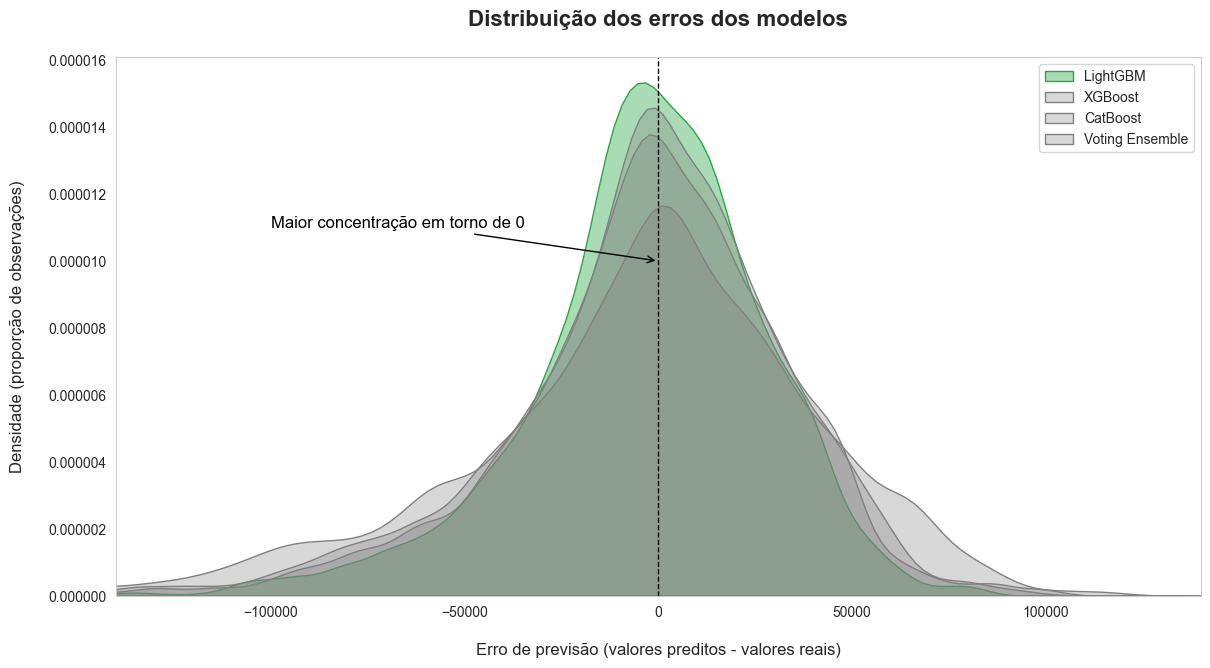

In [164]:
  # Define o tamanho da figura
plt.figure(figsize=(14, 7))

# Plotagem da densidade dos erros para cada modelo
sns.kdeplot(errors_lightgbm, label='LightGBM', fill=True, color='#28a745', alpha=0.4)
sns.kdeplot(errors_xgboost, label='XGBoost', fill=True, color='gray', alpha=0.3)
sns.kdeplot(errors_catboost, label='CatBoost', fill=True, color='gray', alpha=0.3)
sns.kdeplot(errors_voting_ensemble, label='Voting Ensemble', fill=True, color='gray', alpha=0.3)

# Linha vertical destacando o erro zero
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Ajusta o formato dos rótulos do eixo y para números normais (não em notação científica)
plt.ticklabel_format(style='plain', axis='y')

# Configuração do título e dos eixos
plt.title('Distribuição dos erros dos modelos\n', fontsize=16, fontweight='bold')
plt.xlabel('\nErro de previsão (valores preditos - valores reais)', fontsize=12)
plt.ylabel('Densidade (proporção de observações)\n', fontsize=12)

# Limita os valores do eixo x para focar em erros mais relevantes
plt.xlim([-140000, 140000])

# Adiciona legenda para identificar os modelos
plt.legend()

# Adiciona anotação para destacar a concentração em torno de 0
plt.annotate(
    'Maior concentração em torno de 0',
    xy=(0, 1.0e-5),  # Coordenadas do ponto a ser destacado
    xytext=(-100000, 1.1e-5),  # Coordenadas do texto
    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->'),  # Propriedades da seta
    fontsize=12, color='black'  # Configurações do texto
)

# Remove a grade de fundo para deixar o gráfico mais limpo
plt.grid(False)

# Exibe o gráfico
plt.show()


**Análise da distribuição dos Erros**

**1. Modelo LightGBM:**
-  A curva de densidade do LightGBM é a mais **estreita e alta**, indicando que a maioria dos erros está concentrada em torno de zero.
- Essa característica sugere um modelo **preciso e consistente**, com previsões próximas aos valores reais.
-  A **leve inclinação à esquerda** da curva indica que o modelo apresenta uma tendência a subestimar os valores reais em alguns casos, ou seja, os erros negativos (previsões menores que o real) são ligeiramente mais comuns.

**2. Demais Modelos (XGBoost, CatBoost e Voting Ensemble):**
- As curvas de densidade dos outros modelos, incluindo o Voting Ensemble, apresentam formato mais **largo e baixo** em comparação ao LightGBM.
- Isso implica que os erros desses modelos possuem maior variabilidade e dispersão, o que sugere previsões menos precisas em relação ao LightGBM.
- Ainda assim, essas curvas estão centradas em torno de zero, um indicativo de que, mesmo com maior dispersão, as previsões estão relativamente próximas dos valores reais.

**3. Amplitude dos Erros:**
- A **largura das bases das curvas** revela a presença de erros extremos (outliers) para todos os modelos. Esses outliers indicam observações mais difíceis de prever com precisão, possivelmente devido a características únicas ou não representativas nos dados.

**4. Densidade em torno de zero:**
- A concentração significativa dos erros em torno de zero, especialmente no LightGBM, reforça que os modelos estão conseguindo gerar previsões **geralmente próximas aos valores reais**, com diferenças pequenas na maioria das observações.

## 11. Comparação: valores reais x valores preditos

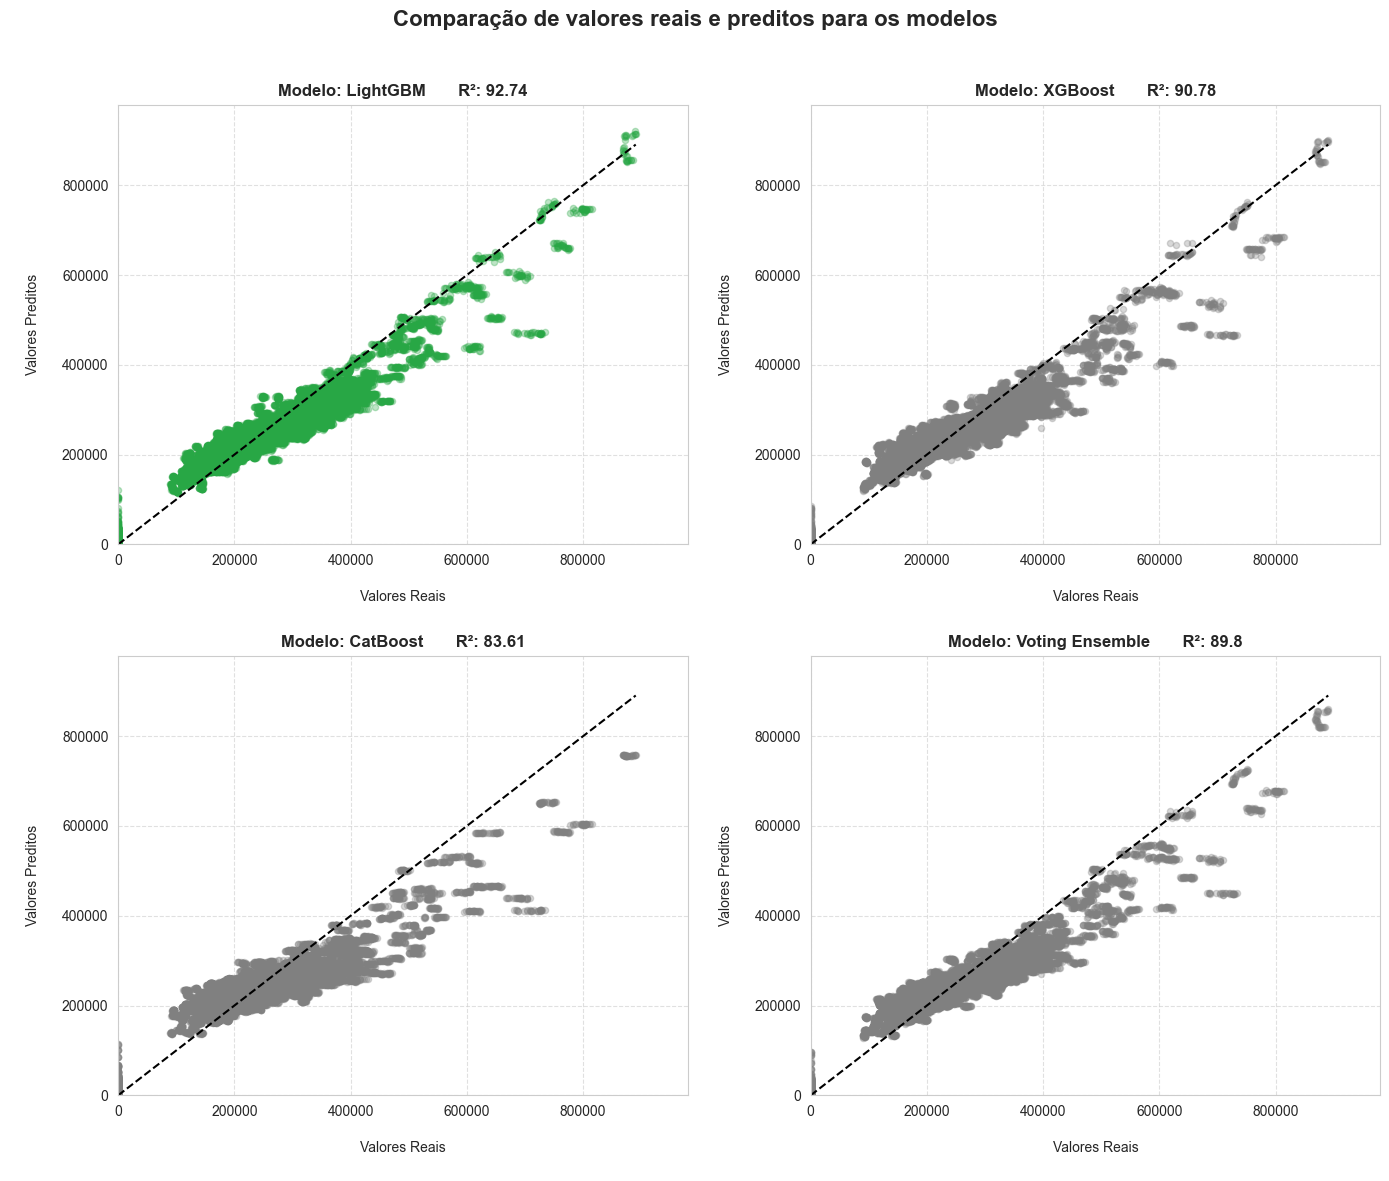

In [ ]:
# Criar subplots com grade 2x2 para os gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Lista com os dados do modelo: nome, previsões, cor e R² (ajustado para exibição)
models_data = [
    ('LightGBM', predictions_lightgbm, '#28a745', round(results_mdls.iloc[0, 4] * 100, 2)),
    ('XGBoost', predictions_xgboost, 'gray', round(results_mdls.iloc[1, 4] * 100, 2)),
    ('CatBoost', predictions_catboost, 'gray', round(results_mdls.iloc[2, 4] * 100, 2)),
    ('Voting Ensemble', predictions_voting_ensemble, 'gray', round(results_ve.iloc[0, 4] * 100, 2))
]

# Loop para iterar pelos modelos e seus respectivos eixos (subplots)
for ax, (model_name, predictions, color, r2) in zip(axes.flatten(), models_data):  
    # Gráfico de dispersão dos valores reais x preditos
    ax.scatter(y_test, predictions, alpha=0.3, color=color, label=model_name, s=20)  
    # Linha de referência (diagonal ideal: predito = real)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black', linewidth=1.5)  
    
    # Títulos e rótulos para cada gráfico individual
    ax.set_title(f'Modelo: {model_name}       R²: {r2}', fontsize=12, fontweight='bold')
    ax.set_xlabel('\nValores Reais\n', fontsize=10)
    ax.set_ylabel('\nValores Preditos\n', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)  # Grade para facilitar a leitura
    ax.set_xlim([y_test.min() * 0.9, y_test.max() * 1.1])  # Ajusta os limites do eixo X
    ax.set_ylim([y_test.min() * 0.9, y_test.max() * 1.1])  # Ajusta os limites do eixo Y

# Título geral da figura (aplicado a todos os subplots)
fig.suptitle('Comparação de valores reais e preditos para os modelos', fontsize=16, fontweight='bold')

# Ajuste de espaçamentos entre os gráficos para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Exibir a figura com os subplots
plt.show()


**Comparação: valores reais x valores preditos**

**1. LightGBM:**

O modelo LightGBM apresentou o melhor desempenho geral, com uma alta concentração de pontos próximos à linha de referência, indicando previsões bastante alinhadas aos valores reais. Observando a dispersão, fica evidente a maior consistência e menor presença de outliers ou grandes erros.

**2. XGBoost e Voting Ensemble:**

Ambos os modelos tiveram desempenhos razoáveis, mas apresentam maior dispersão em comparação ao LightGBM. O XGBoost mostra uma leve melhoria em relação ao Voting Ensemble, que combina previsões de diferentes algoritmos, mas ainda apresentam alguns desvios consideráveis para valores extremos.

**3. CatBoost:**

O modelo CatBoost foi o que apresentou maior distanciamento entre os valores preditos e reais. É visível uma maior concentração de erros, especialmente para faixas intermediárias de valores reais, indicando que há necessidade maior afinamento no hiperparâmetros.

**4. Métrica R²:**

A métrica R² avalia o ajuste do modelo aos dados reais. Valores mais próximos de 100% indicam maior acurácia e menor erro residual. O **LightGBM** lidera com o maior coeficiente de determinação, reforçando seu desempenho superior, já o **CatBoost** em comparação aos demais reflete necessidade de melhor ajuste.
